# Gradient descent on bandwidth parameter (1-dim)

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, jacfwd, jacrev
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from svgd import SVGD
from metrics import ksd

cpu


/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
n=100
d=1
stepsize = 0.01
n_iter_max = 500 # 100 slightly to little, this should be all right
# grid_length = 25
bandwidth = 1

# from utils import log_gaussian_mixture
# logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])
from jax.scipy.stats import norm

@jit
def logp(x):
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1)) 

svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWar

# Define optimizer

In [3]:
n=100
d=1
stepsize = 0.01
n_iter_max = 500 # 100 slightly to little, this should be all right
# grid_length = 25
bandwidth = 1

# from utils import log_gaussian_mixture
# logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])
from jax.scipy.stats import norm

@jit
def logp(x):
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1)) 

svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))

In [4]:
svgd_stepsize = stepsize

def loss(rkey, bandwidth, ksd_bandwidth=1):
    """Sample particles, perform SVGD, and output estimated KSD between target p and particles xout."""
    xout, _ = svgd_fix.svgd(rkey, svgd_stepsize, bandwidth, n_iter_max)
    return ksd(xout, logp, ksd_bandwidth)

@jit
def update_bandwidth(rkey, bandwidth, stepsize):
    return bandwidth - stepsize * jacfwd(loss, argnums=1)(rkey, bandwidth)

def optimize_bandwidth(bandwidth, stepsize, n_steps):
    log = [bandwidth]
    for step in tqdm(range(n_steps)):
        svgd_fix.newkey()
        bandwidth = update_bandwidth(svgd_fix.rkey, bandwidth, stepsize)
        log.append(bandwidth)
    return bandwidth, log

# Experiments
## 1
* Plot KSD and grad(KSD) for bandwidths 0, ..., 10.000.
* Optimize bandwidth, initializing at various points along the bandwidth grid.

ISSUE: when bandwidth is less than around 0.25, gradients become NaN.

In [5]:
svgd_fix.newkey()
xout, _ = svgd_fix.svgd(svgd_fix.rkey, stepsize, bandwidth=1, n_iter=200)
np.mean(xout)

JIT COMPILING...
Done compiling in 0.31856274604797363 seconds.


DeviceArray(-0.00874445, dtype=float32)

In [6]:
bandwidth_grid = np.logspace(-10, 15, base=2, num=200)
# bandwidth_grid = np.linspace(0.5, 1.5, 200)
losses = np.array([loss(rkey, h) for rkey, h in zip(random.split(svgd_fix.rkey, len(bandwidth_grid)), bandwidth_grid)])

JIT COMPILING...
Done compiling in 0.1108548641204834 seconds.


In [7]:
grad_losses = np.array([jacfwd(loss, argnums=1)(rkey, h) for rkey, h in zip(random.split(svgd_fix.rkey, len(bandwidth_grid)), bandwidth_grid)])

JIT COMPILING...
Done compiling in 1.5878942012786865 seconds.


In [8]:
svgd_fix.newkey()
grad_losses2 = np.array([jacfwd(loss, argnums=1)(rkey, h) for rkey, h in zip(random.split(svgd_fix.rkey, len(bandwidth_grid)), bandwidth_grid)])

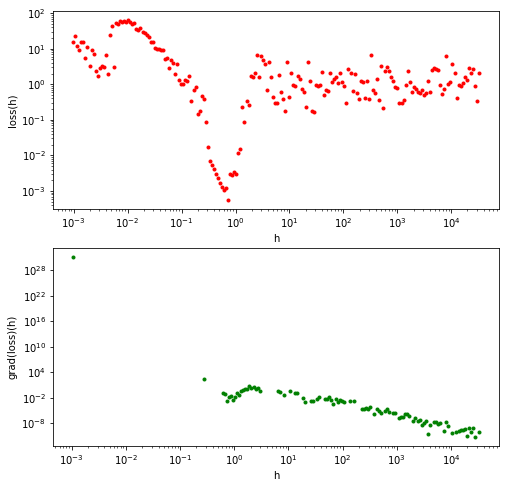

In [9]:
plt.figure(1, figsize=[8, 8])

plt.subplot(211)
plt.plot(bandwidth_grid, losses, "r.")
plt.xlabel("h")
plt.ylabel("loss(h)")
plt.yscale("log")
plt.xscale("log")

plt.subplot(212)
plt.plot(bandwidth_grid, grad_losses, "g.")
plt.xlabel("h")
plt.ylabel("grad(loss)(h)")
plt.yscale("log")
plt.xscale("log")

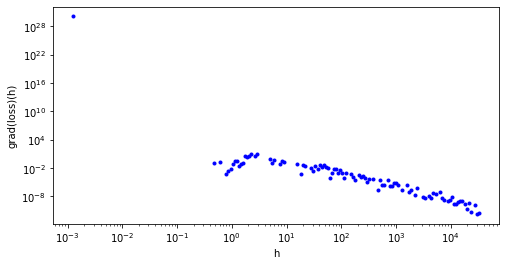

In [10]:
plt.figure(1, figsize=[8, 4])
plt.plot(bandwidth_grid, grad_losses2, "b.")
plt.xlabel("h")
plt.ylabel("grad(loss)(h)")
plt.yscale("log")
plt.xscale("log")

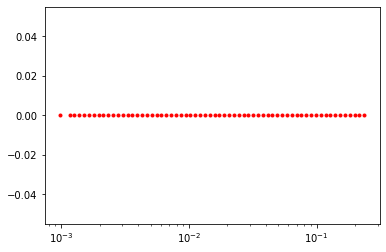

In [11]:
nanh = bandwidth_grid[np.isnan(grad_losses)]
plt.plot(nanh , np.zeros(len(nanh)), "r.")
plt.xscale("log")

In [12]:
np.isnan(grad_losses) == np.isnan(grad_losses2)

DeviceArray([ True, False,  True, False,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True, 

In [13]:
h=0.25

jacfwd(loss, argnums=1)(rkey, h)

NameError: name 'rkey' is not defined